In [1]:
import torch
from torch import nn
import rdkit
from tqdm import tqdm
from rdkit import Chem
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

In [2]:
import sascorer

In [3]:
torch.set_default_device('cuda')

In [4]:
from constants import *

In [5]:
import  generator as G
import discriminator as D
import rewardnet as R
import mlp as M
import rgcn
from molecularmetrics import MolecularMetrics

In [6]:
zinc250k=pd.read_csv("250k_rndm_zinc_drugs_clean.csv", nrows=10_000)
sampled=zinc250k.sample(1000).reset_index(drop=True)

In [7]:
zinc250k.head(5)

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [8]:
logp_scale=zinc250k['logP'].quantile([0.05,0.95]).values
qed_scale=zinc250k['qed'].quantile([0.05,0.95]).values
sas_scale=zinc250k['SAS'].quantile([0.05,0.95]).values

# Atom count (with atomic numbers)
![atom_count](atom_counts.png "Atom Count")

In [9]:
def graph_from_smiles(smiles,return_mol=False):
    rdkit_mol=Chem.MolFromSmiles(smiles)
    X=[list(MOLS.keys()).index(i.GetAtomicNum()) for i in rdkit_mol.GetAtoms()]
    N=len(X)
    A=torch.zeros(N,N)
    for i in range(N):
        for j in range(N):
            try:
                A[i,j]=BONDS[rdkit_mol.GetBondBetweenAtoms(i,j).GetBondType()]
            except:
                pass
    X=nn.functional.one_hot(torch.tensor(X), num_classes=len(MOLS))
    A=nn.functional.one_hot(A.to(int), num_classes=len(BONDS)).permute(-1,0,1)
    if return_mol: 
        return X,A,rdkit_mol
    return X,A

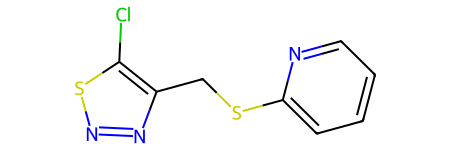

In [10]:
smiles_sample=sampled['smiles'][0]
x,a=graph_from_smiles(smiles_sample)
x=x.to(torch.float32).unsqueeze(0)
a=a.to(torch.float32).unsqueeze(0)
mol0=Chem.MolFromSmiles(smiles_sample)
mol0

In [11]:
def mol_from_graph(x,a,strict=True,print_errors=False):
    assert a.shape[-3]==len(BONDS), "a: [N_BONDS, N_ATOMS, N_ATOMS]"
    assert len(a.shape)==3 or (len(a.shape)==4 and a.shape[0]==1), "batched operation not supported"
    if len(a.shape)==4:
        a=a[0]
        x=x[0]
    X_map=[*MOLS.keys()]
    iBOND = {BONDS[k]:k for k in BONDS}
    mol = Chem.RWMol()
    bonds=frozenset([])
    for node_label in x:
        mol.AddAtom(Chem.Atom(X_map[node_label.argmax().detach().cpu().numpy()]))

    for t,r,c in a[1:,:,:].argwhere().detach().cpu().numpy().tolist():
        if frozenset([r,c]) in bonds: continue
        if r==c: continue
        mol.AddBond(r, c, iBOND[t+1])#t+1 because t=0 now maps to SINGLEBOND because of a[1:,:,:]
        bonds |= frozenset([frozenset([r,c])])
        
    if strict:
        try:
            Chem.SanitizeMol(mol)
        except:
            mol = None
            if print_errors:
                print("error in Chem.SanitizeMol")

    return mol

In [12]:
def sample_gumbel(x,a,temperature=1.0,hard=False,method=None):
    x = nn.functional.gumbel_softmax(x,tau=temperature,hard=hard,dim=-1)
    a = nn.functional.gumbel_softmax(a,tau=temperature,hard=hard,dim=-3)
    return (x,a)

In [13]:
def reward(mol):
    rr=1
    for m in ('logp','sas','qed'):
        if m == 'logp':
            rr *= MolecularMetrics.water_octanol_partition_coefficient_scores([mol], norm=True)
        elif m == 'sas':
            rr *= MolecularMetrics.synthetic_accessibility_score_scores([mol], norm=True)
        elif m == 'qed':
            rr *= MolecularMetrics.quantitative_estimation_druglikeness_scores([mol], norm=True)
    return rr[0]

In [14]:
def gradient_penalty(y, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
    weight = torch.ones(y.size())
    dydx = torch.autograd.grad(outputs=y,
                               inputs=x,
                               grad_outputs=weight,
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]
    #print('dydx',dydx.sum().detach().item())
    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = dydx.norm(dim=1)
    res = ((dydx_l2norm - 1) ** 2).mean()
    #print('res',res.detach().item())
    return res

In [15]:
class Solver:
    def __init__(self, G, D, R, z_dim, lr=1e-3, lambda_wgan=WGAN_BIAS_LAMBDA, lambda_gp=GP_LAMBDA, loss_ema_n=200):
        self.G=G
        self.D=D
        self.R=R
        self.G_opt=torch.optim.AdamW(self.G.parameters(),lr=lr)
        self.D_opt=torch.optim.AdamW(self.D.parameters(),lr=lr)
        self.R_opt=torch.optim.AdamW(self.R.parameters(),lr=lr)
        self.z_dim=z_dim
        self.lambda_wgan=lambda_wgan
        self.lambda_gp=lambda_gp
        self.loss_ema_n=loss_ema_n
    def train(self, dataset, ema_n=200, max_iters=-1):
        graphs = [graph_from_smiles(s,return_mol=True) for s in tqdm(dataset['smiles'][:max_iters],desc='converting graph from smiles...')]
        iterator = tqdm(graphs, desc='training', total=max_iters if max_iters>=0 else None)
        loss_ema=0
        las=[]
        lbs=[]
        lcs=[]
        lds=[]
        les=[]
        loss_sums=[]
        for real_x,real_a,real_mol in iterator:#graphs:
            if max_iters==0: break
            max_iters-=1
            z=sample(self.z_dim)
            real_x=real_x.to(torch.float32).unsqueeze(0)
            real_a=real_a.to(torch.float32).unsqueeze(0)
            
            # =======================
            #   train discriminator
            # =======================
            #print("=== train discriminator")

            # TODO: graph reward
            
            D_x = self.D((real_x,real_a))
            #print("D_x",D_x)
            (fake_x, fake_a) = self.G(z)
            fake_x = fake_x.detach()#detach because we dont want to nudge generator parameter in this part
            fake_a = fake_a.detach()
            #print('fake.sum()',fake_x.sum().item(), fake_a.sum().item())
            (sampled_fake_x, sampled_fake_a) = sample_gumbel(fake_x, fake_a)
            D_G_z = self.D((sampled_fake_x, sampled_fake_a))
            #print("D_G_z",D_G_z.detach().item(),sampled_fake_x.sum().detach().item(), sampled_fake_a.sum().detach().item())
            eps = torch.rand([])
            fake_n=sampled_fake_a.shape[-1]
            real_n=real_a.shape[-1]
            if real_n>fake_n:
                fake_a_tmp = torch.zeros_like(real_a)
                fake_a_tmp[...,:,:fake_n,:fake_n]=fake_a
                fake_x_tmp = torch.rand_like(real_x)/1e9
                fake_x_tmp[...,:fake_x.shape[-2],:]=fake_x
                sampled_fake_a=fake_a_tmp
                sampled_fake_x=fake_x_tmp
            elif real_n!=fake_n:
                real_a_tmp = torch.zeros_like(sampled_fake_a)
                real_a_tmp[...,:,:real_n,:real_n]=real_a
                real_x_tmp = torch.rand_like(sampled_fake_x)/1e9
                real_x_tmp[...,:real_x.shape[-2],:]=real_x
                real_a=real_a_tmp
                real_x=real_x_tmp
            #print('real',real_x.shape,real_a.shape)
            #print('sampled_fake',sampled_fake_x.shape,sampled_fake_a.shape)
            (x_hat_x, x_hat_a) = ( #x_hat = e*fake+(1-e)*real where e~U(0,1)
                (eps*sampled_fake_x + (1-eps)*real_x).detach().requires_grad_(True),# 
                (eps*sampled_fake_a + (1-eps)*real_a).detach().requires_grad_(True),# 
            )
            D_x_hat = self.D((x_hat_x, x_hat_a))
            gp_loss = self.lambda_gp*(gradient_penalty(D_x_hat,x_hat_x))#+gradient_penalty(D_x_hat,x_hat_a))
            loss_D = D_G_z-D_x#+gp_loss #GRADIENT PENALTY LOSS IS MAIN CULPRIT FOR NAN
            #if it errors because loss_D is not a scalar, then gp_loss calculations needs a .mean()
            #although, it shouldn't happen when batching has not been implemented
            self.D.zero_grad(set_to_none=True)
            loss_D.backward()
            self.D_opt.step()
            
            # ===================
            #   train rewardnet
            # ===================
            #print("=== train rewardnet")

            real_reward = reward(real_mol)
            fake_reward = reward(mol_from_graph(sampled_fake_x, sampled_fake_a))

            R_x = self.R((real_x, real_a))
            R_G_z = self.R((sampled_fake_x, sampled_fake_a))
            
            loss_V = (R_x - real_reward).abs()# + (R_G_z - fake_reward).abs() <- I'm half afraid that this part will induce too much noice.
                                              # Isn't |R(x)-reward(x)| enough? Can't find it in the paper about this
            self.R.zero_grad(set_to_none=True)
            loss_V.backward()
            self.R_opt.step()
            
            # ===================
            #   train generator
            # =================== 
            #print("=== train generator")

            z=sample(self.z_dim)
            (fake_x, fake_a) = self.G(z)
            #print('fake.sum()',fake_x.sum().detach().item(), fake_a.sum().detach().item())
            (sampled_fake_x, sampled_fake_a) = sample_gumbel(fake_x, fake_a)
            D_G_z = self.D((sampled_fake_x, sampled_fake_a))
            #print("D_G_z",D_G_z.detach().item(),sampled_fake_x.sum().detach().item(), sampled_fake_a.sum().detach().item())
            #print(fake_x.sum(),sampled_fake_x.sum())
            loss_G_wgan = -D_G_z

            real_reward = reward(real_mol)
            fake_reward = reward(mol_from_graph(sampled_fake_x, sampled_fake_a))

            R_x = self.R((real_x, real_a))
            R_G_z = self.R((sampled_fake_x, sampled_fake_a))
            
            loss_RL = -R_G_z

            # I have no idea what alpha is. I dont think it's in the paper
            alpha = 1#torch.abs(loss_G_wgan.detach() / (loss_RL.detach()+1e-9)).detach()
            loss_molgan = self.lambda_wgan * loss_G_wgan + (1 - self.lambda_wgan) * alpha * loss_RL
            la,lb,lc,ld,le=(loss_molgan.detach().cpu(), loss_V.detach().cpu(), loss_D.detach().cpu(), loss_G_wgan.detach().cpu(), loss_RL.detach().cpu())
            la=float(la)
            lb=float(lb)
            lc=float(lc)
            ld=float(ld)
            le=float(le)
            loss_sum = float(loss_molgan.detach().cpu()+loss_V.detach().cpu()+loss_D.detach().cpu())
            
            loss_ema = (1-1/ema_n)*loss_ema + loss_sum/ema_n
            self.G.zero_grad(set_to_none=True)
            loss_molgan.backward()
            self.G_opt.step()
            #print(f"loss:{loss_ema:.2f} loss_molgan:{la:.2f} loss_V:{lb:.2f} loss_D:{lc:.2f} loss_G_wgan:{ld:.2f} loss_RL:{le:.2f}")


            las.append(la)
            lbs.append(lb)
            lcs.append(lc)
            lds.append(ld)
            les.append(le)
            loss_sums.append(loss_sum)

            
            iterator.set_description(f"loss:{loss_ema:.2f} gp_loss:{gp_loss.detach().cpu():.2f}")# loss_molgan:{la:.2f} loss_V:{lb:.2f} loss_D:{lc:.2f} loss_G_wgan:{ld:.2f} loss_RL:{le:.2f}")
        return las, lbs, lcs, lds, les, loss_sums


In [16]:
rgcn=reload(rgcn)
D=reload(D)
G=reload(G)
R=reload(R)

In [17]:
Z_DIM=32
g = G.Generator(Z_DIM, [128, 256, 512], [], [], 9)
#input_dim, rgcn_dims, i_dims, j_dims, final_mlp_dims
d = D.Discriminator([128, 64], [128], [128], [128, 64])
r = R.Rewarder([128, 64], [128], [128], [128, 64])

#g = G.Generator(32, [128, 256, 512], [], [], 9)
##input_dim, rgcn_dims, i_dims, j_dims, final_mlp_dims
#d = D.Discriminator([128, 256, 128, 128, 64], [128, 64], [128, 64], [128, 64])
#r = R.Rewarder([128, 256, 128, 128, 64], [128, 64], [128, 64], [128, 64])

In [18]:
solver = Solver(g,d,r,Z_DIM,lr=1e-3)

In [19]:
result=solver.train(zinc250k,max_iters=1000)

loss:-78.93 gp_loss:9.99: 100%|████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.33it/s]


In [20]:
123

123

Text(0.5, 0, 'iteration')

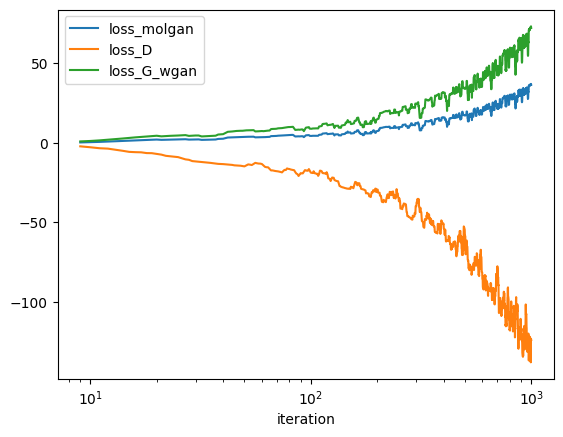

In [21]:
result_df=pd.DataFrame(result,index=["loss_molgan", "loss_V", "loss_D", "loss_G_wgan", "loss_RL", "loss_sum"]).T
ax=result_df.drop(columns=['loss_sum','loss_V','loss_RL']).rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-8,8))
ax.set_xlabel("iteration")

Text(0.5, 0, 'iteration')

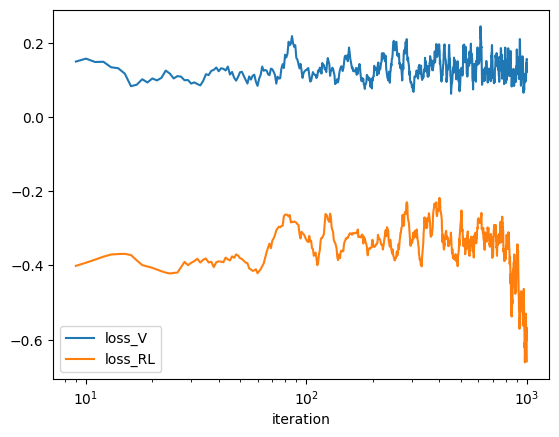

In [22]:
ax=result_df[['loss_V','loss_RL']].rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-.6,.3))
ax.set_xlabel("iteration")

Text(0.5, 1.0, 'loss_sum')

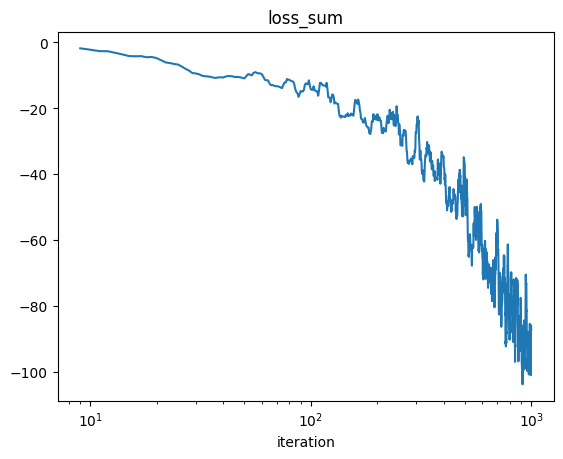

In [23]:
ax=result_df['loss_sum'].rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-10,10))
ax.set_xlabel("iteration")
ax.set_title("loss_sum")

Text(0.5, 0, 'iteration')

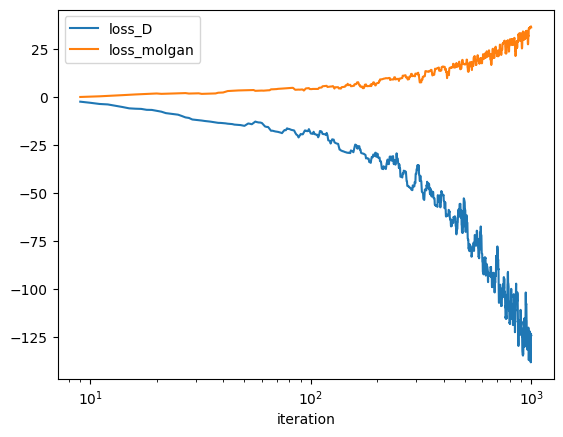

In [24]:
ax=result_df[['loss_D','loss_molgan']].rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-.6,.3))
ax.set_xlabel("iteration")

In [25]:
GP_LAMBDA

10.0

In [26]:
with torch.no_grad():
    tmp=tqdm(range(10000))
    for _ in tmp:
        generated=solver.G(sample(Z_DIM))
        sampled_graph=sample_gumbel(*generated,hard=True)
        tmpmol=(mol_from_graph(*sampled_graph,print_errors=False))
        tmp.set_description(f'{sampled_graph[1][...,1:,:,:].sum()}')
        if tmpmol is not None:
            display(tmpmol)

61.0: 100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 282.25it/s]


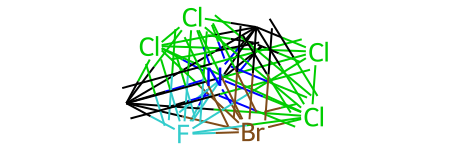

In [27]:
with torch.no_grad():
    tmp=sample_gumbel(*solver.G(sample(Z_DIM)),hard=True)
    display(mol_from_graph(*tmp,strict=False))

In [28]:
tmp[1][...,1:,:,:].sum()

tensor(58., device='cuda:0')

In [29]:
tmp[0].mean(-2)

tensor([[0.2222, 0.1111, 0.0000, 0.1111, 0.0000, 0.0000, 0.4444, 0.1111, 0.0000]],
       device='cuda:0')

In [30]:
x.mean(-2)

tensor([[0.5714, 0.2143, 0.0000, 0.0000, 0.0000, 0.1429, 0.0714, 0.0000, 0.0000]],
       device='cuda:0')

In [31]:
from IPython.display import display
for generated_graph in zip(*generated):
    tmp=(sample_gumbel(*generated_graph))
    break

In [32]:
mol_from_graph(*tmp,print_errors=True)

error in Chem.SanitizeMol


WGAN-GP formula

$\underset{G}{\min}\underset{D}{\max}{[D(x)-D(G(z))+\lambda(\nabla_\hat{x}||D(\hat{x})||_2-1)^2]};x\sim X;z\sim p(z)$